In [1]:
import cPickle as pkl
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

'''
import random
'''

'\nimport random\n'

In [2]:
#filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1752_3600s.p"

In [3]:
results = pkl.load(open(filepath))

In [4]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

In [5]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.47675153749
YAL038W 122.93809989083661
YJL189W 115.66034482762224
YCR012W 112.14782458765491
YOL086C 117.69469509745605
YLR110C 108.31024771541968
YLR044C 193.17040229891074
YKL152C 115.56526237143666


In [6]:
transcriptome_shah = pkl.load(open('../../parameters/transcriptome_shah.p'))

In [7]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print prot, prot_per_transcript_speeds[prot]

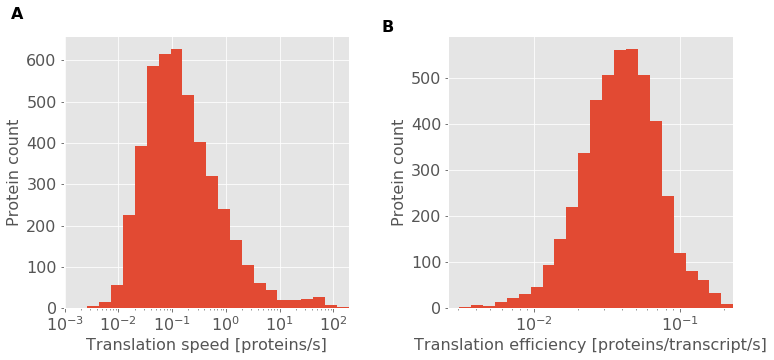

In [8]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 25))
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 700, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 32))
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

plt.show()

For Innsbruck poster:

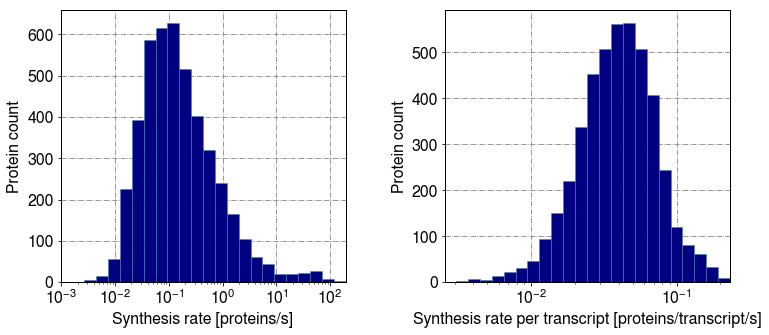

In [10]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname':'FreeSans'}

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121, facecolor='white')
n, bins, patches = ax.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001),
                                                                        np.log10(max(prot_speeds.values())), 25), 
                           color='navy', edgecolor='steelblue')
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('Synthesis rate [proteins/s]', fontsize=16, **hfont)
ax.set_ylabel('Protein count', fontsize=16, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=16, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=16, **hfont)
#plt.text(0.0001, 666, "A", fontsize=16, weight="bold", **hfont)

ax = fig.add_subplot(122, facecolor='white')
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                  np.log10(max(prot_per_transcript_speeds.values())), 32), 
                           color='navy', edgecolor='steelblue')
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('Synthesis rate per transcript [proteins/transcript/s]', fontsize=16, **hfont)
ax.set_ylabel('Protein count', fontsize=16, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=16, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=16, **hfont)
#plt.text(0.0011, 595, "B", fontsize=16, weight="bold", **hfont)

plt.savefig("protein_translation_speeds.png")

In [11]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [12]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [14]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [15]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [16]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [17]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [18]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [19]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [20]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

In [21]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

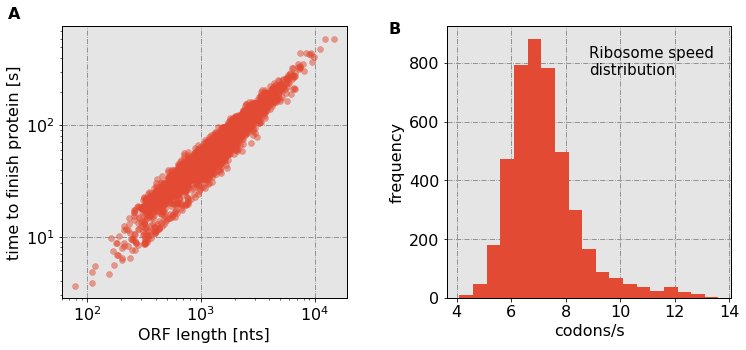

In [22]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5)
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(20, 900, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(1.5, 900, "B", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.show()

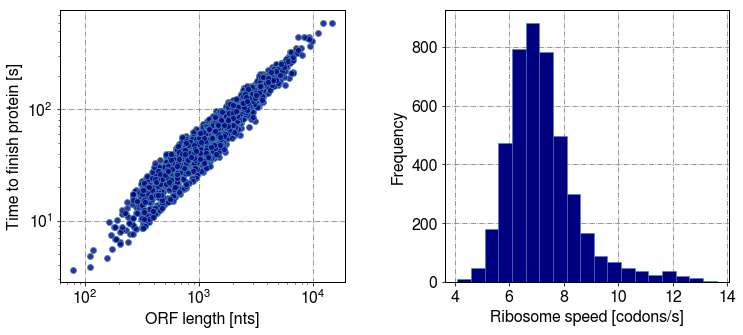

In [24]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname':'FreeSans'}

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121, facecolor='white')
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.8, color='navy', edgecolor='steelblue', linewidth='1')
ax.set_xlabel('ORF length [nts]', fontsize=16, **hfont)
ax.set_ylabel('Time to finish protein [s]', fontsize=16, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=16, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=16, **hfont)
ax.set_yscale('log')
ax.set_xscale('log')

#plt.text(20, 700, "C", fontsize=16, weight="bold", **hfont)

ax = fig.add_subplot(122, facecolor='white')
plt.hist(ribo_speed_dict.values(), 
         bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5), 
                           color='navy', edgecolor='steelblue')
ax.set_xlabel('Ribosome speed [codons/s]', fontsize=16, **hfont)
ax.set_ylabel('Frequency', fontsize=16, **hfont)
plt.setp(plt.gca().get_xticklabels(), fontsize=16, **hfont)
plt.setp(plt.gca().get_yticklabels(), fontsize=16, **hfont)

#plt.text(1.5, 910, "D", fontsize=16, weight="bold", **hfont)
#plt.title("") #, weight="bold")
#ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15, **hfont)

plt.savefig("ribosome_speeds.png")

## Ribosome ramp

In [23]:
import shelve

#filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
filepath = "../../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1753.db"
d = shelve.open(filepath)

In [24]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

This is now a dictionary that contains for every gene an array of the total ribosomes bound at the corresponding codon positions.

In [25]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [26]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [27]:
ramp_genes = set(z.keys()) & set(orf_lengths.keys())
len(ramp_genes)

4326

In [28]:
max_gene_length = max(orf_lengths.values())/3.0
max_gene_length

4911.0

In [29]:
import math

e = []
for j in range(int(max_gene_length)):
    numer = 0.0
    for gene in ramp_genes:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
    denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ramp_genes]) * 1.0
    e.append(numer/denom)

In [30]:
eprime = np.array(e) / (sum(e[449:500]) / 51.0)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  after removing the cwd from sys.path.


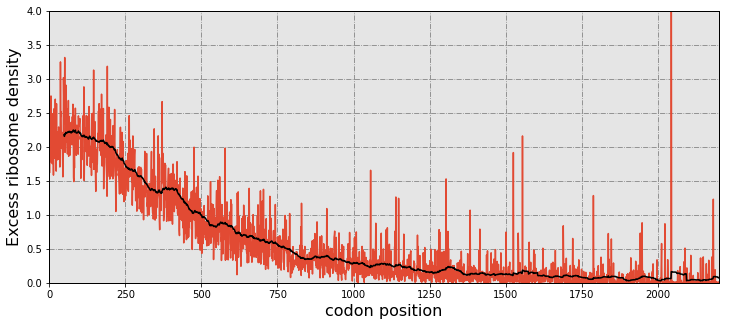

In [31]:
plt.plot(eprime)
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(eprime), 50).plot(style='k')
plt.xlim([0, 2200]);
plt.ylim([0, 4]);

## Codon analysis

In [32]:
transcriptome = pkl.load(open('../../parameters/transcriptome_shah.p'))

In [33]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [34]:
# length of longest polysome in codons
max_codons = len(max(ribo_lattice_dict.values(), key=len))

# fill up with None values
for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], \
                                        [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [35]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)

In [36]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [37]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

In [38]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [39]:
peaks['YDL130W'], peaks['YBR078W']

([],
 [(13, 0.09523809523809523, 6.566023424670845),
  (410, 0.11904761904761904, 8.420466822114825)])

In [40]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

from itertools import chain
def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

from collections import Counter
counter = Counter(flatten_dict_values(anticodons_at_peaks))

import collections as col
counter = col.OrderedDict(sorted(counter.items(), key=lambda t: t[1]))

In [41]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

In [42]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

In [43]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])

In [44]:
counter

OrderedDict([('ccg', 92),
             ('cca', 156),
             ('acg', 211),
             ('ucu', 232),
             ('cuu', 261),
             ('ccc', 267),
             ('ugg', 295),
             ('caa', 309),
             ('ucc', 325),
             ('aac', 329),
             ('gcc', 341),
             ('agu', 342),
             ('gca', 352),
             ('uug', 360),
             ('ugu', 382),
             ('gug', 386),
             ('agc', 403),
             ('uuc', 416),
             ('cau', 429),
             ('aga', 430),
             ('uaa', 441),
             ('cac', 483),
             ('aau', 502),
             ('ugc', 508),
             ('uac', 515),
             ('gua', 571),
             ('uga', 592),
             ('gaa', 632),
             ('uuu', 639),
             ('cgu', 639),
             ('guc', 641),
             ('uau', 672),
             ('cga', 686),
             ('ccu', 790),
             ('cuc', 863),
             ('uag', 907),
             ('guu', 916),
  

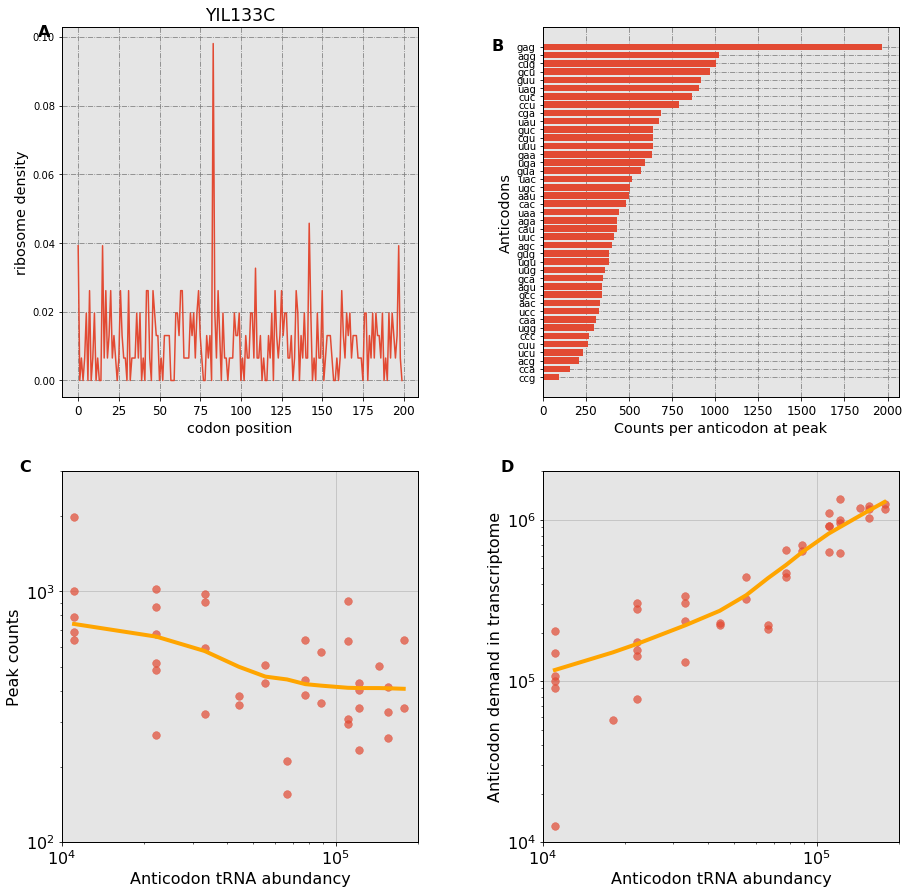

In [45]:
plt.rcParams['figure.figsize'] = (15, 15)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['ytick.labelsize'] = 10

####################################################################
ax = fig.add_subplot(221)

ax.plot(ribo_lattice_df_normalized["YIL133C"])
ax.set_xlabel('codon position')
ax.set_ylabel('ribosome density')
ax.set_title("YIL133C")
        
plt.text(-25, 0.1, "A", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(222)

# make a horizontal bar chart
val = counter.values()    # the bar lengths
pos = np.arange(len(counter))+.5    # the bar centers on the y axis

plt.barh(pos, val, align='center')
plt.yticks(pos, counter.keys())
plt.xlabel('Counts per anticodon at peak')
plt.ylabel('Anticodons')
plt.grid(True)

plt.text(-300, 40, "B", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(223)

dict1 = anticodon_tRNA_abundancy
dict2 = counter
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Peak counts"
fontsize = 16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys, s=60)
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'orange', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e2, 3e3])

plt.text(7e3, 3e3, "C", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(224)

dict1 = anticodon_tRNA_abundancy
dict2 = anticodon_demand_transcriptome
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Anticodon demand in transcriptome"
fontsize=16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys, s=60)
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'orange', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e4, 2e6])

plt.text(7e3, 2e6, "D", fontsize=16, weight="bold")

plt.show()

In [50]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


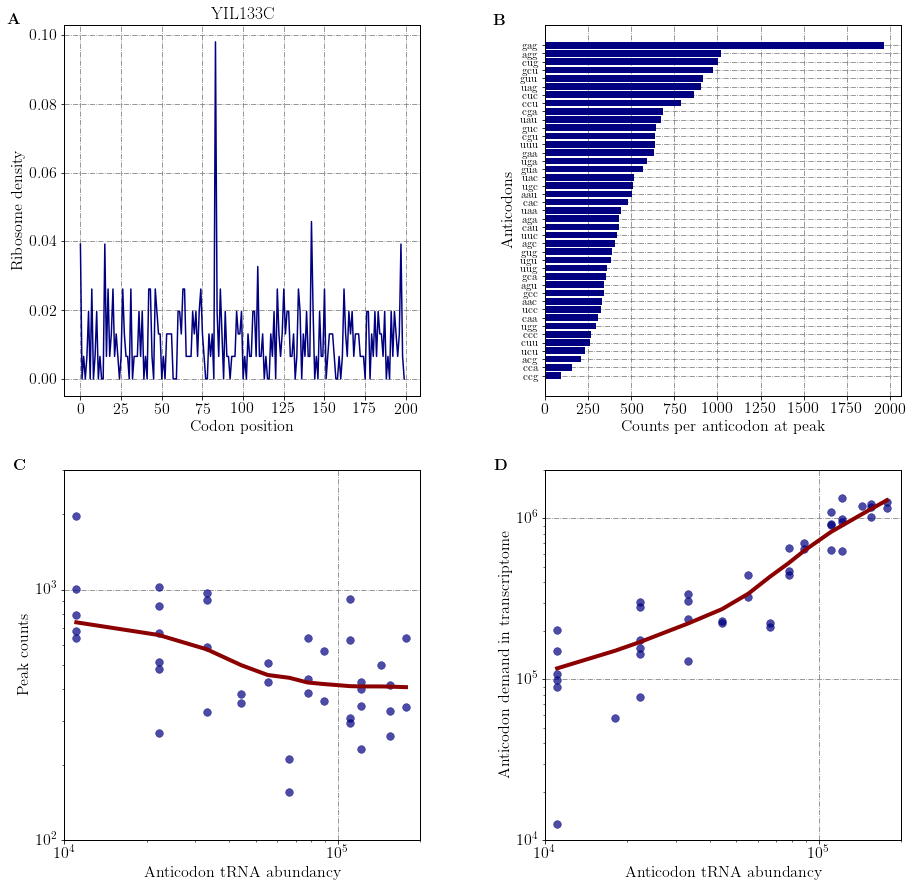

In [57]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'

hfont = {'fontname':'FreeSans'}

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['ytick.labelsize'] = 10

####################################################################
ax = fig.add_subplot(221, axisbg='white')

ax.plot(ribo_lattice_df_normalized["YIL133C"], color='navy')
ax.set_xlabel('Codon position', fontsize=fontsize, **hfont)
ax.set_ylabel('Ribosome density', fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)
ax.set_title("YIL133C", **hfont)
        
plt.text(-45, 0.103, r'\textbf{A}', fontsize=16, weight="bold", **hfont)

####################################################################
ax = fig.add_subplot(222, axisbg='white')

# make a horizontal bar chart
val = counter.values()    # the bar lengths
pos = np.arange(len(counter))+.5    # the bar centers on the y axis

plt.barh(pos, val, align='center', color='navy')
plt.yticks(pos, counter.keys())
plt.xlabel('Counts per anticodon at peak', fontsize=fontsize, **hfont)
plt.ylabel('Anticodons', fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize - 5, **hfont)
plt.grid(True)

plt.text(-300, 43, r'\textbf{B}', fontsize=16, weight="bold", **hfont)

####################################################################
ax = fig.add_subplot(223, axisbg='white')

dict1 = anticodon_tRNA_abundancy
dict2 = counter
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Peak counts"
fontsize = 16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-.')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel, **hfont)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
if yaxislabel:
    ax.set_ylabel(yaxislabel, **hfont)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

scat = plt.scatter(xs, ys, s=60, color='navy')
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'darkred', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e2, 3e3])

plt.text(6.5e3, 3e3, r'\textbf{C}', fontsize=16, weight="bold", **hfont)

####################################################################
ax = fig.add_subplot(224, axisbg='white')

dict1 = anticodon_tRNA_abundancy
dict2 = anticodon_demand_transcriptome
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Anticodon demand in transcriptome"
fontsize=16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-.')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel, **hfont)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
if yaxislabel:
    ax.set_ylabel(yaxislabel, **hfont)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

scat = plt.scatter(xs, ys, s=60, color='navy')
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'darkred', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e4, 2e6])

plt.text(6.5e3, 2e6, r'\textbf{D}', fontsize=16, weight="bold", **hfont)

plt.savefig('ribosome_stalling.pdf', bbox_inches='tight')

In [25]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

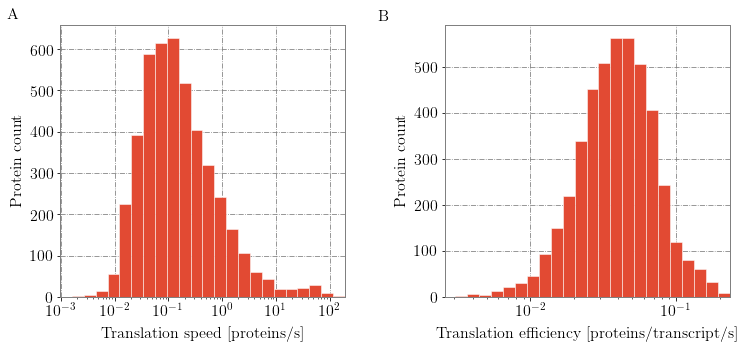

In [26]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(prot_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                  np.log10(max(prot_speeds.values())), 25), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 670, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                  np.log10(max(prot_per_transcript_speeds.values())), 32), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

#plt.show()
plt.savefig('translation_efficiencies.pdf', bbox_inches='tight')

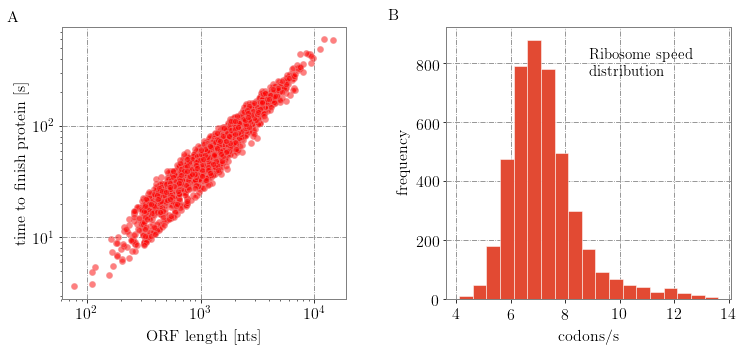

In [27]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5, color='red', edgecolor='lightcoral', linewidth='1')
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(20, 850, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5),
         edgecolor='white')
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(1.5, 950, "B", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.savefig('ribosome_speed.pdf', bbox_inches='tight')

In [52]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, filename=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    # fig =  plt.figure()                

    # ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys, alpha=0.8, color='red', edgecolor='lightcoral', linewidth='1')
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'cornflowerblue', linewidth=4)
    
    #if filename:
    #    plt.savefig(filename, bbox_inches='tight')

    #plt.show()

In [53]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [54]:
transcriptome = pkl.load(open('../../parameters/transcriptome_shah.p'))
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.47675153749
YAL038W 122.93809989083661
YJL189W 115.66034482762224
YCR012W 112.14782458765491
YOL086C 117.69469509745605
YLR110C 108.31024771541968
YLR044C 193.17040229891074
YKL152C 115.56526237143666


4475


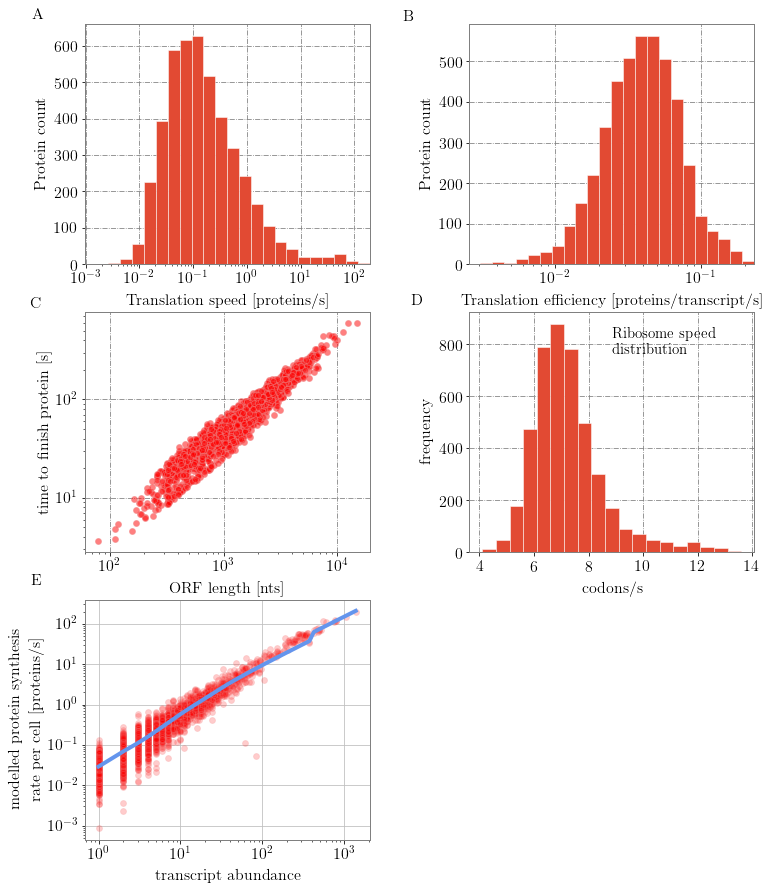

In [59]:
plt.rcParams['figure.figsize'] = (12, 15)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(321)
n, bins, patches = ax.hist(prot_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                  np.log10(max(prot_speeds.values())), 25), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 670, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(322)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                           bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                  np.log10(max(prot_per_transcript_speeds.values())), 32), 
                           edgecolor='white')
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('Protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")


ax = fig.add_subplot(323)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5, color='red', edgecolor='lightcoral', linewidth='1')
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(20, 850, "C", fontsize=16, weight="bold")

ax = fig.add_subplot(324)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5),
         edgecolor='white')
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(1.5, 950, "D", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

ax = fig.add_subplot(325)
scatter_dicts(transcriptome, prot_speeds, "transcript abundance", 
             "modelled protein synthesis\nrate per cell [proteins/s]",
             fontsize = 16,
             filename="amplification.pdf")
plt.text(0.15, 900, "E", fontsize=16, weight="bold")

#plt.show()
plt.savefig('translation_efficiencies_3_by_2.pdf', bbox_inches='tight')